In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/d/ejlok1/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav
/kaggle/input/d/ejlok1/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_youth_fear.wav
/kaggle/input/d/ejlok1/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_near_fear.wav
/kaggle/input/d/ejlok1/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_search_fear.wav
/kaggle/input/d/ejlok1/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_pick_fear.wav
/kaggle/input/d/ejlok1/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_dodge_fear.wav
/kaggle/input/d/ejlok1/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_void_fear.wav
/kaggle/input/d/ejlok1/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_sheep_fear.wav
/kaggle/inp

In [3]:
#import libraries
import os
import pandas as pd
import numpy as np
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd
import tensorflow as tf

2024-07-17 11:11:55.460961: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 11:11:55.461088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 11:11:55.619330: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
tf.random.set_seed(42)

# Paths to datasets
BerlinDB = "/kaggle/input/berlin-database-of-emotional-speech-emodb"
Tess_path = "/kaggle/input/d/ejlok1/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data"



In [5]:
# Load EmoDB dataset
berlin_directory_list = os.listdir(BerlinDB)

file_emotion = []
file_path = []

for dir in berlin_directory_list:
    directories = os.listdir(BerlinDB + "/" + dir)
    
    for file in directories:
        file_path.append(BerlinDB + "/wav/" +file)
        part = file.split(".")[0]
        ele = part[5]
        if ele=='W':
            file_emotion.append('angry')
        elif ele=='E':
            file_emotion.append('disgust')
        elif ele=='A':
            file_emotion.append('fear')
        elif ele=='F':
            file_emotion.append('happy')
        elif ele=='N':
            file_emotion.append('neutral')
        elif ele=='T':
            file_emotion.append('sad')
        else:
            file_emotion.append('boredom')

# DataFrame for EmoDB
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Berlin_df = pd.concat([emotion_df, path_df], axis=1)

In [51]:
Berlin_df.head()

,Emotions,Path
0,happy,/kaggle/input/berlin-database-of-emotional-spe...
1,happy,/kaggle/input/berlin-database-of-emotional-spe...
2,angry,/kaggle/input/berlin-database-of-emotional-spe...
3,angry,/kaggle/input/berlin-database-of-emotional-spe...
4,angry,/kaggle/input/berlin-database-of-emotional-spe...


In [6]:
# Load TESS dataset
Tess_dir_list = os.listdir(Tess_path)
emotions_tess = []
path_tess = []

for it in Tess_dir_list:
    directories = os.listdir(Tess_path + '/' + it)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            emotions_tess.append('surprise')
        else:
            emotions_tess.append(part)
        path_tess.append(Tess_path + it + '/' + file)
        
# DataFrame for TESS
emotion_tess_df = pd.DataFrame(emotions_tess, columns=['Emotions'])
path_tess_df = pd.DataFrame(path_tess, columns=['Path'])
Tess_df = pd.concat([emotion_tess_df, path_tess_df], axis=1)

In [7]:
# Combine datasets
combined_df = pd.concat([Berlin_df, Tess_df], ignore_index=True)

In [8]:
# Display the combined DataFrame
combined_df.head()

,Emotions,Path
0,happy,/kaggle/input/berlin-database-of-emotional-spe...
1,happy,/kaggle/input/berlin-database-of-emotional-spe...
2,angry,/kaggle/input/berlin-database-of-emotional-spe...
3,angry,/kaggle/input/berlin-database-of-emotional-spe...
4,angry,/kaggle/input/berlin-database-of-emotional-spe...


In [9]:
combined_df['Emotions'].value_counts()

Emotions
angry       527
neutral     479
happy       471
fear        469
sad         462
disgust     446
surprise    400
boredom      81
Name: count, dtype: int64

In [10]:
combined_df.isnull().sum()

Emotions    0
Path        0
dtype: int64

In [11]:
# Remove 'boredom' values
combined_df = combined_df[combined_df['Emotions'] != 'boredom']

In [12]:
# Function to sample 400 values per emotion
def balance_emotions(df, num_samples=400):
    balanced_df = pd.DataFrame(columns=df.columns)
    for emotion in df['Emotions'].unique():
        emotion_df = df[df['Emotions'] == emotion]
        if len(emotion_df) >= num_samples:
            sampled_df = emotion_df.sample(n=num_samples, random_state=42)
        else:
            sampled_df = emotion_df
        balanced_df = pd.concat([balanced_df, sampled_df])
    return balanced_df

In [13]:
# Balance the DataFrame
balanced_df = balance_emotions(combined_df)

# Shuffle the DataFrame to mix the samples
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
# Display the value counts to verify
print(balanced_df['Emotions'].value_counts())

Emotions
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64


In [15]:
balanced_df.head()

,Emotions,Path
0,fear,/kaggle/input/d/ejlok1/toronto-emotional-speec...
1,angry,/kaggle/input/d/ejlok1/toronto-emotional-speec...
2,disgust,/kaggle/input/d/ejlok1/toronto-emotional-speec...
3,fear,/kaggle/input/d/ejlok1/toronto-emotional-speec...
4,neutral,/kaggle/input/d/ejlok1/toronto-emotional-speec...


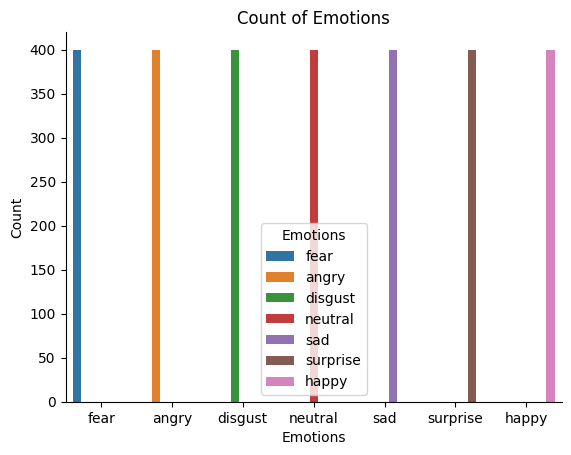

In [16]:
plt.title('Count of Emotions')
sns.countplot(x = balanced_df.Emotions, hue = balanced_df.Emotions)
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

In [17]:
# Function to plot waveplot
def waveplot(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.title(f'Waveplot for {emotion}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()
    
    
# Function to load audio and handle errors
def load_audio(path):
    try:
        data, sampling_rate = librosa.load(path)
        return data, sampling_rate
    except FileNotFoundError:
        print(f"File not found: {path}")
        return None, None
    
def plot_log_mel_spectrogram(data, sampling_rate, emotion, n_fft=2048, hop_length=512, n_mels=128):
    # Compute the Mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    # Convert to log scale (dB)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    # Plot the Mel-spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_mel_spectrogram, sr=sampling_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'log_Mel-Spectrogram for {emotion}')
    plt.xlabel('Time (s)')
    
# Function to plot MFCCs
def plot_mfcc(data, sampling_rate, emotion, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=n_mfcc)
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sampling_rate, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCC for {emotion}')
    plt.xlabel('Time (s)')
    plt.ylabel('MFCC Coefficients')
    plt.show()
    
# Function to plot chromagram
def plot_chromagram(data, sampling_rate, emotion, hop_length=512):
    # Compute the chromagram
    chromagram = librosa.feature.chroma_stft(y=data, sr=sampling_rate, hop_length=hop_length)
    
    # Plot the chromagram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chromagram, sr=sampling_rate, x_axis='time', y_axis='chroma', hop_length=hop_length)
    plt.colorbar()
    plt.title(f'Chromagram for {emotion}')
    plt.xlabel('Time (s)')
    plt.ylabel('Chroma')
    plt.show()


In [55]:
BerlinDB

'/kaggle/input/berlin-database-of-emotional-speech-emodb'

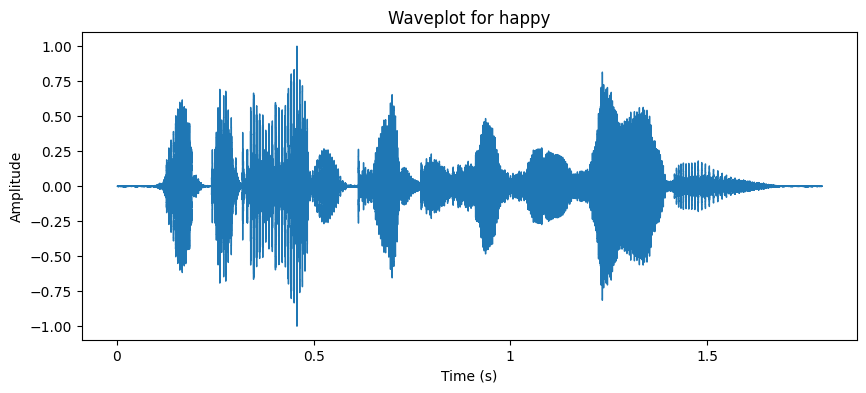

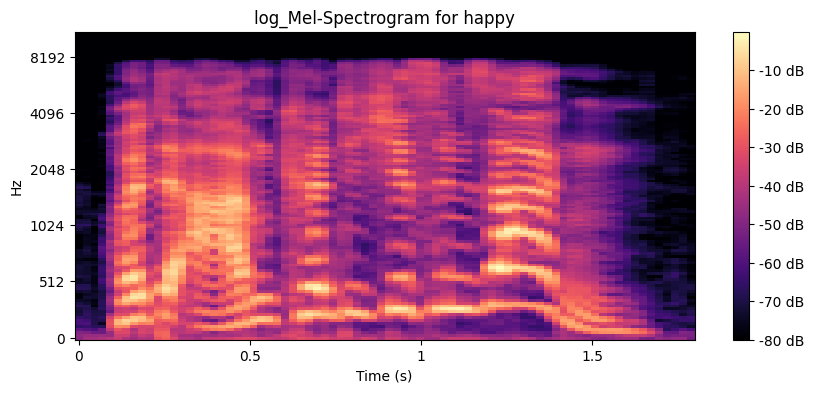

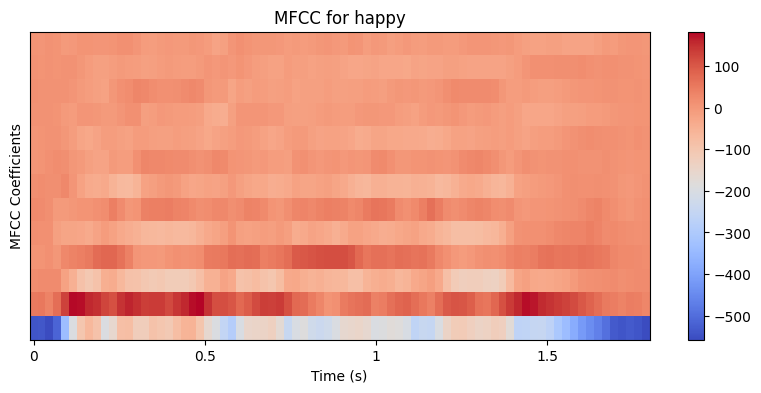

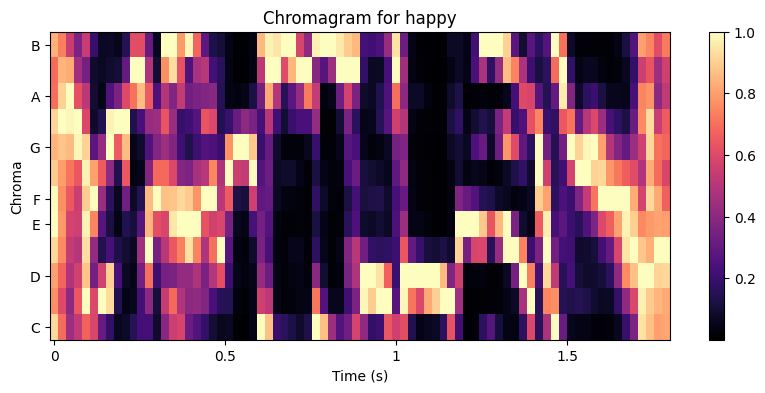

In [57]:
emotion = 'happy'
file_name = np.array(Berlin_df['Path'][Berlin_df['Emotions'] == emotion])[0]  # Get the first file
path = os.path.join(BerlinDB, file_name)


# Load the audio file
data, sampling_rate = load_audio(path)

if data is not None and sampling_rate is not None:
    # Plot waveplot and log-mel spectrogram
    waveplot(data, sampling_rate, emotion)
    plot_log_mel_spectrogram(data, sampling_rate, emotion)
    plot_mfcc(data, sampling_rate, emotion)
    plot_chromagram(data, sampling_rate, emotion)

    # Play the audio
    ipd.display(ipd.Audio(path))

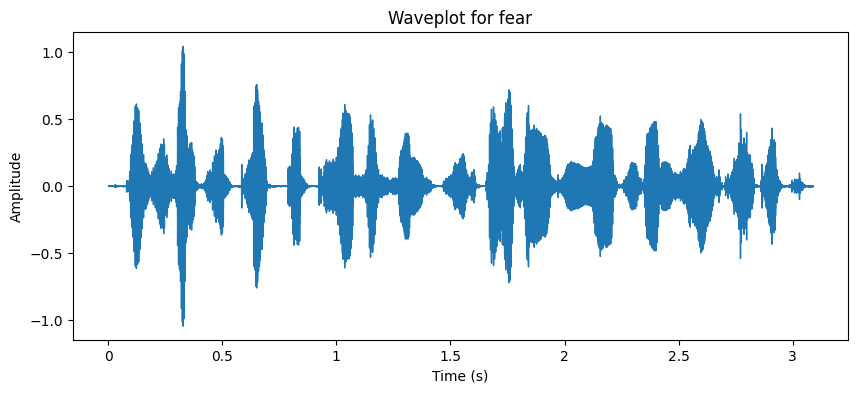

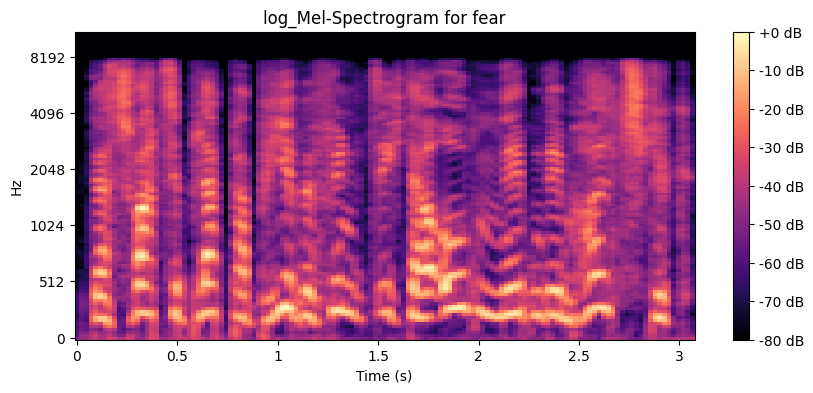

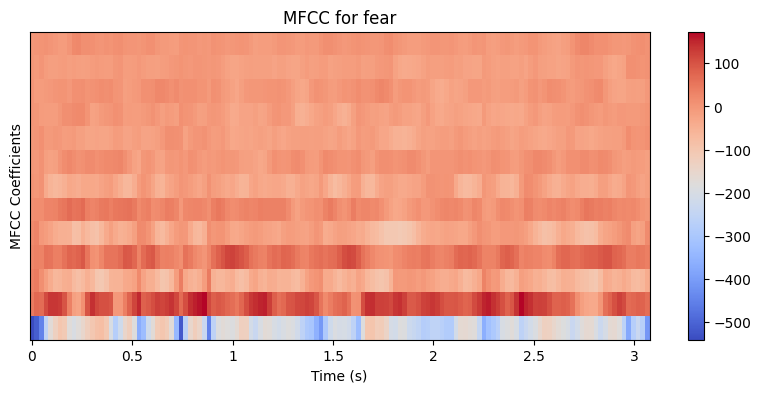

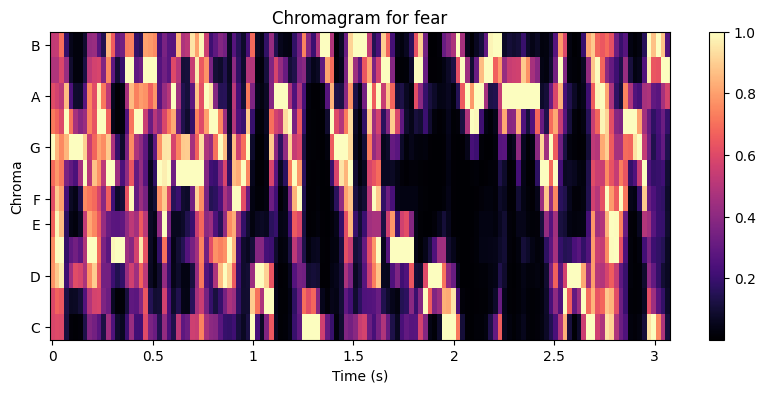

In [58]:
emotion = 'fear'
file_name = np.array(Berlin_df['Path'][Berlin_df['Emotions'] == emotion])[0]  # Get the first file
path = os.path.join(BerlinDB, file_name)


# Load the audio file
data, sampling_rate = load_audio(path)

if data is not None and sampling_rate is not None:
    # Plot waveplot and log-mel spectrogram
    waveplot(data, sampling_rate, emotion)
    plot_log_mel_spectrogram(data, sampling_rate, emotion)
    plot_mfcc(data, sampling_rate, emotion)
    plot_chromagram(data, sampling_rate, emotion)

    # Play the audio
    ipd.display(ipd.Audio(path))

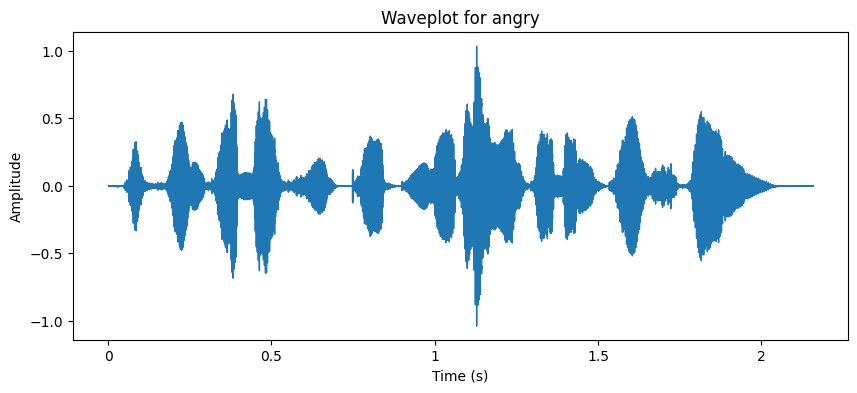

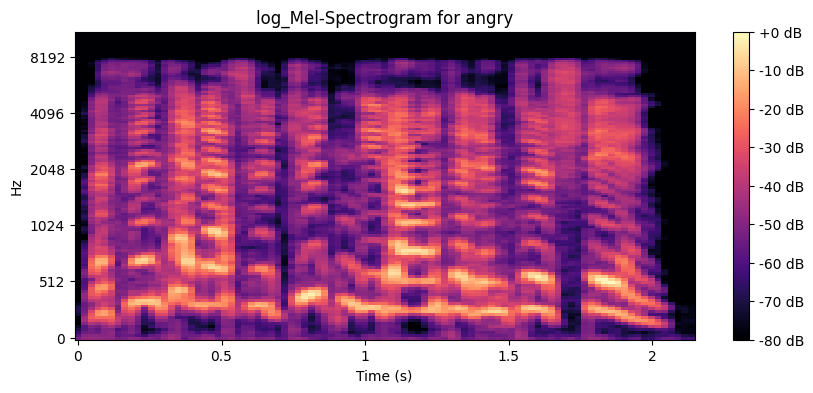

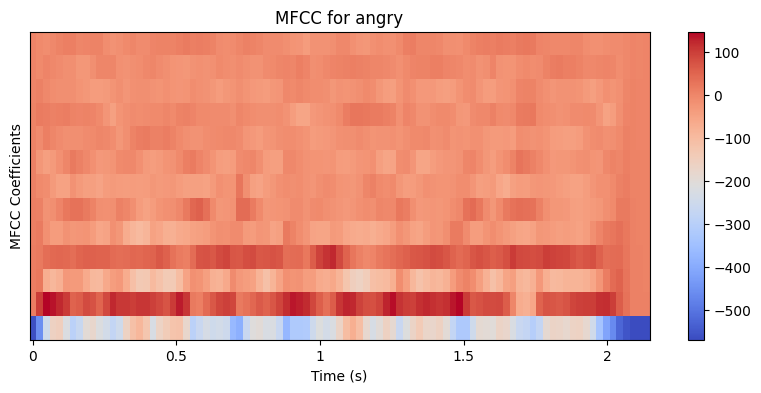

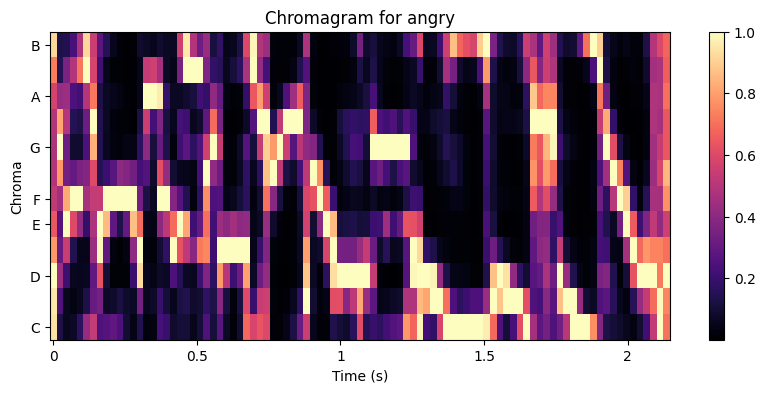

In [59]:
emotion = 'angry'
file_name = np.array(Berlin_df['Path'][Berlin_df['Emotions'] == emotion])[0]  # Get the first file
path = os.path.join(BerlinDB, file_name)


# Load the audio file
data, sampling_rate = load_audio(path)

if data is not None and sampling_rate is not None:
    # Plot waveplot and log-mel spectrogram
    waveplot(data, sampling_rate, emotion)
    plot_log_mel_spectrogram(data, sampling_rate, emotion)
    plot_mfcc(data, sampling_rate, emotion)
    plot_chromagram(data, sampling_rate, emotion)

    # Play the audio
    ipd.display(ipd.Audio(path))

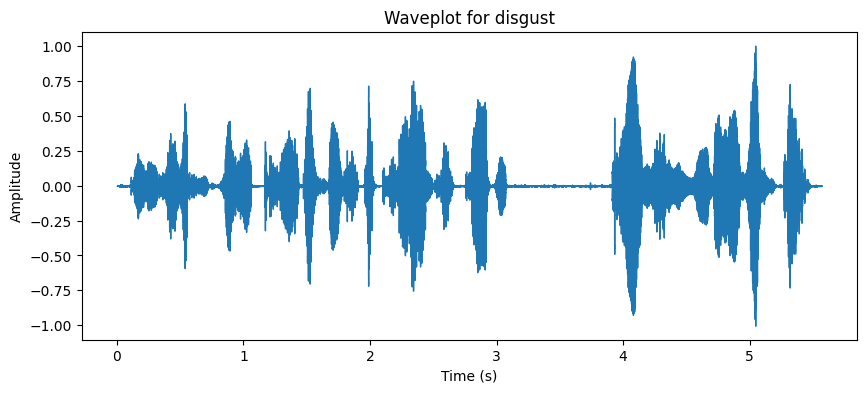

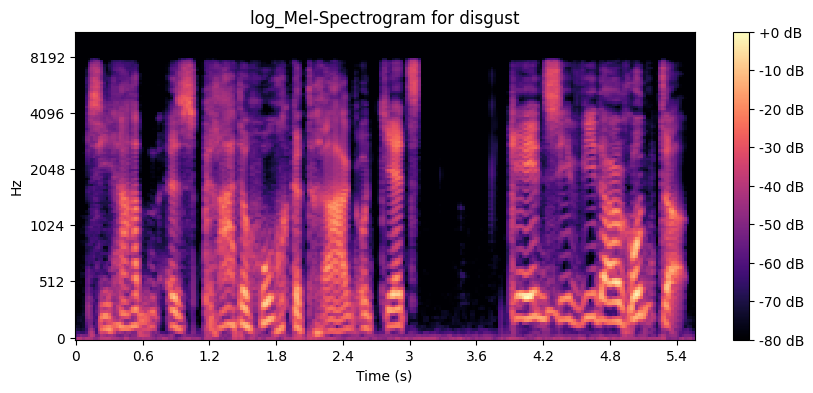

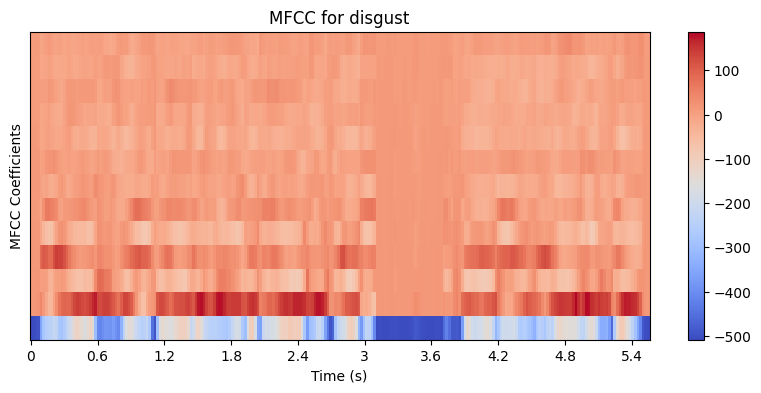

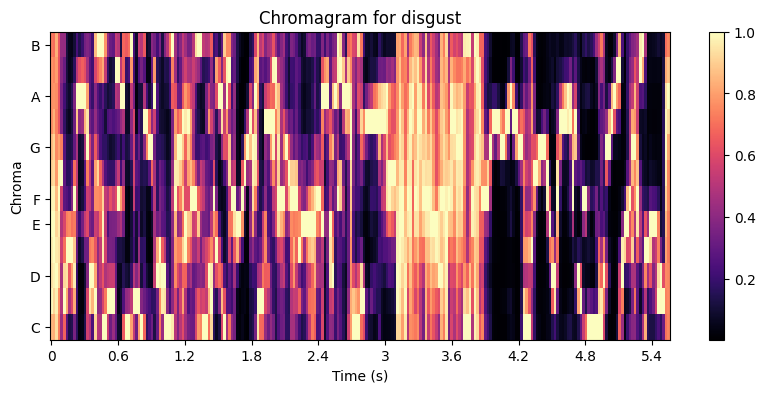

In [60]:
emotion = 'disgust'
file_name = np.array(Berlin_df['Path'][Berlin_df['Emotions'] == emotion])[0]  # Get the first file
path = os.path.join(BerlinDB, file_name)


# Load the audio file
data, sampling_rate = load_audio(path)

if data is not None and sampling_rate is not None:
    # Plot waveplot and log-mel spectrogram
    waveplot(data, sampling_rate, emotion)
    plot_log_mel_spectrogram(data, sampling_rate, emotion)
    plot_mfcc(data, sampling_rate, emotion)
    plot_chromagram(data, sampling_rate, emotion)

    # Play the audio
    ipd.display(ipd.Audio(path))

File not found: /kaggle/input/d/ejlok1/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set dataOAF_Pleasant_surprise/OAF_met_ps.wav


/tmp/ipykernel_33/2216047418.py:14: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sampling_rate = librosa.load(path)
/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
